# Finding Winners in the Public Markets using Historical Financials p.2

Now that we have a dataset with the metrics/measurements, we can create scores based on Value, Quality, Growth, Margin Growth and Balance Sheet. I have removed companies in Biotechnology, Banks, and Insurance industries because their metrics and financials are very different from most companies. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import simfin as sf

#import datetime
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

#display
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 5000

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import warnings
warnings.filterwarnings('ignore')

In [2]:
%%time 
sf.set_data_dir('~/simfin_data/')
# sf.set_api_key(api_key='free')
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')
#Data for US
market = 'us'
# Daily Share-Prices.
df_prices = sf.load_shareprices(variant='daily', market=market, refresh_days = 1)

Dataset "us-shareprices-daily" on disk (1 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Wall time: 1min 4s


In [3]:
#import pickle
df = pd.read_pickle('dfpickle')
latest = pd.read_pickle('latestpickle')

#Business Services, Consumer Cyclical, Consumer Defensive, Industrials, Technology
# df = df[df.Sector.isin(['Business Services',np.nan, 'Consumer Cyclical', \
#                         'Consumer Defensive', 'Industrials', 'Technology','Other'])]

df= df[~df.Industry.isin(['Biotechnology','Banks','Insurance - Specialty',
                          'Insurance - Property & Casualty','Insurance','Insurance - Life'])]

train = df[['Ticker','Company Name', 'Report Date', 'publish_date', 'year', 'quarter',
    'Sector', 'Industry', 'mc', 'ev', 'ev_sales', 'ev_ebitda', 'ebitda_margin', 
    'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin','fat','cash_mc', 
    'fcf_yield','cfo_yield', 'bs_debt_ebitda','bs_ppe_apev','bs_current_ratio',
    'cf_invest_apr','lt_invest_apr','acq_divest_apr',
    'rev_growth_1', 'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
    'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1','gp_margrow_1', 'np_margrow_1',
    'cfo_margrow_1', 'fcf_margrow_1','close_pct']]

test = latest[['Ticker','Company Name', 'Report Date', 'publish_date', 'year', 'quarter',
    'Sector', 'Industry', 'mc', 'ev', 'ev_sales', 'ev_ebitda', 'ebitda_margin',
    'cf_invest_apr','lt_invest_apr','acq_divest_apr',
    'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin','fat','cash_mc', 
    'fcf_yield','cfo_yield', 'bs_debt_ebitda','bs_ppe_apev','bs_current_ratio',
    'rev_growth_1','gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
    'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1','gp_margrow_1', 'np_margrow_1',
    'cfo_margrow_1', 'fcf_margrow_1','close_pct']]

train = train.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)

train = train[(~train.close_pct.isnull())&(~train.ev.isnull())&(train.year != 2010)&(train.close_pct<2)
              &(~train.gp_margin.isnull())&(train.Ticker != 'SINO')&(~train.cfo_growth_1.isnull())&\
              (~train.oi_growth_1.isnull())& (~train.fcf_growth_1.isnull())&(~train.np_margrow_1.isnull())&\
              (~train.bs_current_ratio.isnull())]
              

In [4]:
train.isnull().sum()

Ticker                  0
Company Name            0
Report Date             0
publish_date            0
year                    0
quarter                 0
Sector               1286
Industry             1286
mc                      0
ev                      0
ev_sales                0
ev_ebitda               0
ebitda_margin           0
gp_margin               0
np_margin               0
cfo_margin              0
fcf_margin              0
fat                     0
cash_mc                 0
fcf_yield               0
cfo_yield               0
bs_debt_ebitda       3235
bs_ppe_apev             0
bs_current_ratio        0
cf_invest_apr         135
lt_invest_apr       30964
acq_divest_apr      29361
rev_growth_1            0
gp_growth_1             0
oi_growth_1             0
ni_growth_1             0
ebitda_growth_1         0
cfo_growth_1            0
fcf_growth_1            0
ebitda_margrow_1        0
gp_margrow_1            0
np_margrow_1            0
cfo_margrow_1           0
fcf_margrow_

In [5]:
train.shape

(44288, 40)

In [6]:
df.columns

Index(['Ticker', 'Report Date', 'id', 'year', 'quarter', 'publish_date',
       'revenue', 'cogs', 'gp', 'oi', 'ni', 'shares', 'rnd', 'ebitda_oi',
       'ebitda_ni', 'ebitda', 'ebitda_margin', 'fat', 'gp_margin', 'np_margin',
       'cash', 'st_debt', 'lt_debt', 'inventory', 'ppe', 'receivables',
       'payables', 'current_assets', 'current_liabilities', 'cfo', 'capex',
       'lt_invest', 'acq_divest', 'cfi', 'dividends_paid', 'buyback', 'fcf',
       'cfo_margin', 'fcf_margin', 'Date', 'Close', 'Adj. Close', 'close_pct',
       'adj_close_pct', 'SimFinId', 'Company Name', 'IndustryId', 'Sector',
       'Industry', 'mc', 'cash_mc', 'fcf_yield', 'cfo_yield', 'se_yield', 'ev',
       'ev_sales', 'ev_ebitda', 'bs_ppe_apev', 'bs_current_ratio',
       'bs_debt_ebitda', 'rev_growth_1', 'gp_growth_1', 'oi_growth_1',
       'ni_growth_1', 'ebitda_growth_1', 'cfo_growth_1', 'fcf_growth_1',
       'ebitda_margrow_1', 'fat_growth_1', 'gp_margrow_1', 'np_margrow_1',
       'cfo_margrow_1', 'fc

# Functions

In [7]:
def newline(p1, p2):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax])
    ax.add_line(l)
    return l

### Creating the following functions: analyze(), trainset(), testset(), manual(), check_score()

### Analyze(x)

Input a Industry as x. For example, analyze('Application Software'). Unique industries are generated below.

The function will split the metrics by deciles relative to its peers. Top of the decile receives a score of 10, lowest of the decile receives score of 1.

Then I group those scores by Value, Quality, Growth, Margin Growth, and Balance Sheet strength. I assign weights to these categories based on their correlation to stock price performance in the past for each industry.

In [8]:
df['Industry'].unique()

array(['Medical Diagnostics & Research', 'Metals & Mining',
       'Health Care Providers', 'Airlines', 'Asset Management',
       'Consulting & Outsourcing', 'Semiconductors',
       'Industrial Products', 'Retail - Apparel & Specialty',
       'Computer Hardware', 'Transportation & Logistics',
       'Aerospace & Defense', 'Drug Manufacturers',
       'Medical Distribution', 'Education', 'Autos', 'Business Services',
       'Medical Devices', nan, 'Engineering & Construction',
       'Communication Equipment', 'Communication Services', 'Consulting',
       'Truck Manufacturing', 'Application Software',
       'Consumer Packaged Goods', 'Credit Services',
       'Oil & Gas - Integrated', 'Utilities - Regulated',
       'Packaging & Containers', 'Building Materials',
       'Farm & Construction Machinery', 'REITs', 'Employment Services',
       'Industrial Distribution', 'Brokers & Exchanges',
       'Medical Instruments & Equipment', 'Steel', 'Chemicals',
       'Oil & Gas - Refining 

In [9]:
#Using different weights for different categories
#input industry in x
def analyze(x):
    print(x)
    data = train[train.Industry.isin([x])].reset_index(drop = True)
    data_test = test[test.Industry.isin([x])].reset_index(drop = True)

    #create score columns
    data['ev_sales_score'] = pd.qcut(data.ev_sales, 10 ,labels = False, duplicates = 'drop').map(lambda x:((10-x)))
    data['ev_ebitda_score'] = np.where(data.ev_ebitda<0,0,pd.qcut(data.ev_ebitda, 10 ,labels = False, \
                                                                  duplicates = 'drop').map(lambda x:((10-x))))
    
    data['bs_debt_ebitda_score'] = pd.qcut(data.bs_debt_ebitda, 10, labels = False, duplicates = 'drop').map(lambda x: (10-x)) 
    
    for x in data.columns[data.columns.isin(['ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
   'fat', 'cash_mc', 'fcf_yield', 'cfo_yield','bs_ppe_apev', 'bs_current_ratio', 
    'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
   'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
   'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
   'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1'])]:
        data[''.join([x,'_score'])] = pd.qcut(data[x], 10, labels = False, duplicates = 'drop')

    #calc correlations and get highly correlated features
    correl = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                    reset_index().rename(columns = {'index':'features'})

    correl = correl[(correl.features.str.contains('score'))&(correl.close_pct > 0.03)]
    features = pd.Series(correl.features.tolist())
     
    print(features)
    
    data['score'] = np.mean(data[features], axis =1)
    data['round_score'] = round(data.score)

    #Value features and weights
    value_features = features[features.str.contains('yield|ev_sales|ev_ebitda')].to_list()
    quality_features = features[features.str.contains('margin|fat')].to_list()
    growth_features = features[features.str.contains('growth')].to_list()
    margrow_features = features[features.str.contains('margrow')].to_list()
    bs_features = features[features.str.contains('bs|cash|vest')].to_list()

    data['value_score'] = np.nanmean(data[value_features], axis = 1)
    data['quality_score'] = np.nanmean(data[quality_features], axis = 1)
    data['growth_score'] = np.nanmean(data[growth_features], axis = 1)
    data['margrow_score'] = np.nanmean(data[margrow_features], axis = 1)
    data['bs_score'] = np.nanmean(data[bs_features], axis = 1)

    data['round_value_score'] = round(data.value_score)
    data['round_quality_score'] = round(data.quality_score)
    data['round_growth_score'] = round(data.growth_score)
    data['round_margrow_score'] = round(data.margrow_score)
    data['round_bs_score'] = round(data.bs_score)

    weights = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                reset_index().rename(columns = {'index':'features'})

    weights = weights[(weights.features.str.contains('round_.+_score'))]
    weights.close_pct = weights.close_pct/weights.close_pct.sum()

    value_weight = float(weights.loc[weights.features == 'round_value_score','close_pct'])
    growth_weight = float(weights.loc[weights.features == 'round_growth_score','close_pct'])
    quality_weight = float(weights.loc[weights.features == 'round_quality_score','close_pct'])
    margin_growth_weight = float(weights.loc[weights.features == 'round_margrow_score','close_pct'])
    bs_weight = float(weights.loc[weights.features == 'round_bs_score','close_pct'])
    
    print('Value Weight: ', value_weight)
    print('Growth Weight: ', growth_weight)
    print('Quality Weight: ', quality_weight)
    print('Margin Growth Weight: ', margin_growth_weight)
    print('Balance Sheet Weight: ', bs_weight)
    print('\n')

    #create weighted scores based on correlation
    data['score'] = np.nansum([(data.value_score * value_weight), (data.growth_score * growth_weight),\
                    (data.quality_score * quality_weight), (data.margrow_score * margin_growth_weight),
                              (data.bs_score * bs_weight)], axis = 0)

    data['round_score'] = round(data.score)

    data_dict = {}

    features = ['ev_sales', 'ev_ebitda',
       'ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
       'fat', 'cash_mc', 'fcf_yield', 'cfo_yield', 'bs_debt_ebitda',
       'bs_ppe_apev', 'bs_current_ratio', 'cf_invest_apr','lt_invest_apr','acq_divest_apr',
       'rev_growth_1', 'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
       'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
       'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1']

    for x in features:
        data_dict.setdefault(x, [])
        data_dict[x].append(pd.qcut(data[x], 10, retbins = True, duplicates = 'drop')[1])
        
    for x in data_dict.values():
        x[0][0] = -np.inf
        x[0][len(x[0])-1] = np.inf
    
    print(data_dict)
    print('\n')
    
    #OVERALL SCORES CHART
    print('Overall Scores')
    print(data.groupby(['round_score']).agg({'Ticker':'count','close_pct':'mean'}))
    data.groupby(['round_score'])['close_pct'].mean().plot.bar()
    plt.show()
    
    score = data.groupby(['year','round_score'])['close_pct'].mean()

    num = (score.reset_index().year.unique().__len__())
    
    for x in range(num):
        a = data.year.unique().min()
        print(data.Industry.unique())
        print(a + x)
        print(data[data.year == (a+x)].groupby('round_score').agg({'Ticker':'count','close_pct':'mean'}))
        score.unstack('round_score').iloc[x].plot.bar()
        p1 = [1,np.mean(score.unstack('round_score').iloc[x])]
        p2 = [15,np.mean(score.unstack('round_score').iloc[x])]
        newline(p1,p2)
        plt.show()

    data_test['ev_sales_score'] = pd.cut(data_test['ev_sales'], bins = data_dict['ev_sales'][0], labels = False, duplicates = 'drop').\
                                        map(lambda x: (10-x))
    data_test['ev_ebitda_score'] = np.where(data_test['ev_ebitda']<0,0,pd.cut(data_test['ev_ebitda'], bins = data_dict['ev_ebitda'][0], labels = False, duplicates = 'drop').\
                                            map(lambda x: (10-x)))
    
    data_test['bs_debt_ebitda_score'] = pd.cut(data_test.bs_debt_ebitda, bins = data_dict['bs_debt_ebitda'][0],\
                                               labels = False, duplicates = 'drop').map(lambda x: (10-x))

    features = ['ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
   'fat', 'cash_mc', 'fcf_yield', 'cfo_yield','bs_ppe_apev', 'bs_current_ratio', 
   'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
   'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
   'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
   'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1']

    for x in features:
        data_test[''.join([x,'_score'])] = pd.cut(data_test[x], bins = data_dict[x][0], labels = False, duplicates = 'drop')

    data_test['value_score'] = np.nanmean(data_test[value_features], axis = 1)
    data_test['quality_score'] = np.nanmean(data_test[quality_features], axis = 1)
    data_test['growth_score'] = np.nanmean(data_test[growth_features], axis = 1)
    data_test['margrow_score'] = np.nanmean(data_test[margrow_features], axis = 1)
    data_test['bs_score'] = np.nanmean(data_test[bs_features], axis = 1)

    data_test['round_value_score'] = round(data_test.value_score)
    data_test['round_quality_score'] = round(data_test.quality_score)
    data_test['round_growth_score'] = round(data_test.growth_score)
    data_test['round_margrow_score'] = round(data_test.margrow_score)
    data_test['round_bs_score'] = round(data_test.bs_score)

    data_test['score'] = np.nansum([(data_test.value_score * value_weight), (data_test.growth_score * growth_weight),\
                        (data_test.quality_score * quality_weight), (data_test.margrow_score * margin_growth_weight),\
                                   (data_test.bs_score * bs_weight)], axis = 0)

    data_test['round_score'] = round(data_test.score)
    

    print('TEST DATASET RESULTS')
    print(data_test.Industry.unique())
    data_test.groupby('round_score')['close_pct'].mean().plot.bar()
    plt.show()

### Trainset and Testset

Testset is latest dataset as of the last quarter for that company. 
Trainset is all data prior to the last quarter for that company. 
We create deciles using the trainset to estimate scores for the testset.

Trainset(x). Input industry for x.
Testset(x). Input industry for x.

Returns a dataframe of all companies in that industry with their decile scores.

In [10]:
#Return Train set
def trainset(x):
#     print(x)
    data = train[train.Industry.isin([x])].reset_index(drop = True)

    #create score columns
    data['ev_sales_score'] = pd.qcut(data.ev_sales, 10 ,labels = False, duplicates = 'drop').map(lambda x:((10-x)))
    data['ev_ebitda_score'] = np.where(data.ev_ebitda <0,0,pd.qcut(data.ev_ebitda, 10 ,labels = False,\
                                                                   duplicates = 'drop').map(lambda x:((10-x))))
    
    data['bs_debt_ebitda_score'] = pd.qcut(data.bs_debt_ebitda, 10, labels = False, duplicates = 'drop').map(lambda x: (10-x))
    
    for x in data.columns[data.columns.isin(['ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
   'fat', 'cash_mc', 'fcf_yield', 'cfo_yield','bs_ppe_apev', 'bs_current_ratio',
   'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
   'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
   'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
   'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1'])]:
        data[''.join([x,'_score'])] = pd.qcut(data[x], 10, labels = False, duplicates = 'drop' )

    #calc correlations and get highly correlated features
    correl = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                    reset_index().rename(columns = {'index':'features'})

    correl = correl[(correl.features.str.contains('score'))&(correl.close_pct > 0.03)]
    features = pd.Series(correl.features.tolist())
     
#     print(features)
    
    #Value features and weights
    value_features = features[features.str.contains('yield|ev_sales|ev_ebitda')].to_list()
    quality_features = features[features.str.contains('margin|fat')].to_list()
    growth_features = features[features.str.contains('growth')].to_list()
    margrow_features = features[features.str.contains('margrow')].to_list()
    bs_features = features[features.str.contains('bs|cash|vest')].to_list()

    data['value_score'] = np.nanmean(data[value_features], axis = 1)
    data['quality_score'] = np.nanmean(data[quality_features], axis = 1)
    data['growth_score'] = np.nanmean(data[growth_features], axis = 1)
    data['margrow_score'] = np.nanmean(data[margrow_features], axis = 1)
    data['bs_score'] = np.nanmean(data[bs_features], axis = 1)

    data['round_value_score'] = round(data.value_score)
    data['round_quality_score'] = round(data.quality_score)
    data['round_growth_score'] = round(data.growth_score)
    data['round_margrow_score'] = round(data.margrow_score)
    data['round_bs_score'] = round(data.bs_score)

    weights = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                reset_index().rename(columns = {'index':'features'})

    weights = weights[(weights.features.str.contains('round_.+_score'))]
    weights.close_pct = weights.close_pct/weights.close_pct.sum()

    value_weight = float(weights.loc[weights.features == 'round_value_score','close_pct'])
    growth_weight = float(weights.loc[weights.features == 'round_growth_score','close_pct'])
    quality_weight = float(weights.loc[weights.features == 'round_quality_score','close_pct'])
    margin_growth_weight = float(weights.loc[weights.features == 'round_margrow_score','close_pct'])
    bs_weight = float(weights.loc[weights.features == 'round_bs_score','close_pct'])
    
#     print('Value Weight: ', value_weight)
#     print('Growth Weight: ', growth_weight)
#     print('Quality Weight: ', quality_weight)
#     print('Margin Growth Weight: ', margin_growth_weight)
#     print('Balance Sheet Weight: ', bs_weight)
#     print('\n')

    #create weighted scores based on correlation
    data['score'] = np.nansum([(data.value_score * value_weight), (data.growth_score * growth_weight),\
                    (data.quality_score * quality_weight), (data.margrow_score * margin_growth_weight),
                              (data.bs_score * bs_weight)], axis = 0)

    data['round_score'] = round(data.score)
    
    return data.sort_values('score', ascending = False)

In [11]:
#returns scores for your test set by Industry. 
#input industry in x
def testset(x):
    data = train[train.Industry.isin([x])].reset_index(drop = True)
    data_test = test[test.Industry.isin([x])].reset_index(drop = True)

    #create score columns
    data['ev_sales_score'] = pd.qcut(data.ev_sales, 10 ,labels = False, duplicates = 'drop').map(lambda x:((10-x)))
    data['ev_ebitda_score'] = np.where(data.ev_ebitda<0,0,pd.qcut(data.ev_ebitda, 10 ,labels = False, \
                                                                  duplicates = 'drop').map(lambda x:((10-x))))
    
    data['bs_debt_ebitda_score'] = pd.qcut(data.bs_debt_ebitda, 10, labels = False, duplicates = 'drop').map(lambda x: (10-x))
        
    for x in data.columns[data.columns.isin(['ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
   'fat', 'cash_mc', 'fcf_yield', 'cfo_yield','bs_ppe_apev', 'bs_current_ratio',
   'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
   'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
   'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
   'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1'])]:
        data[''.join([x,'_score'])] = pd.qcut(data[x], 10, labels = False, duplicates = 'drop')

    #calc correlations and get highly correlated features
    correl = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                    reset_index().rename(columns = {'index':'features'})

    correl = correl[(correl.features.str.contains('score'))&(correl.close_pct > 0.03)]
    features = pd.Series(correl.features.tolist())
    
    data['score'] = np.mean(data[features], axis =1)
    data['round_score'] = round(data.score)

    #Value features and weights
    value_features = features[features.str.contains('yield|ev_sales|ev_ebitda')].to_list()
    quality_features = features[features.str.contains('margin|fat')].to_list()
    growth_features = features[features.str.contains('growth')].to_list()
    margrow_features = features[features.str.contains('margrow')].to_list()
    bs_features = features[features.str.contains('bs|cash|vest')].to_list()

    data['value_score'] = np.nanmean(data[value_features], axis = 1)
    data['quality_score'] = np.nanmean(data[quality_features], axis = 1)
    data['growth_score'] = np.nanmean(data[growth_features], axis = 1)
    data['margrow_score'] = np.nanmean(data[margrow_features], axis = 1)
    data['bs_score'] = np.nanmean(data[bs_features], axis = 1)

    data['round_value_score'] = round(data.value_score)
    data['round_quality_score'] = round(data.quality_score)
    data['round_growth_score'] = round(data.growth_score)
    data['round_margrow_score'] = round(data.margrow_score)
    data['round_bs_score'] = round(data.bs_score)

    weights = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                reset_index().rename(columns = {'index':'features'})

    weights = weights[(weights.features.str.contains('round_.+_score'))]
    weights.close_pct = weights.close_pct/weights.close_pct.sum()

    value_weight = float(weights.loc[weights.features == 'round_value_score','close_pct'])
    growth_weight = float(weights.loc[weights.features == 'round_growth_score','close_pct'])
    quality_weight = float(weights.loc[weights.features == 'round_quality_score','close_pct'])
    margin_growth_weight = float(weights.loc[weights.features == 'round_margrow_score','close_pct'])
    bs_weight = float(weights.loc[weights.features == 'round_bs_score','close_pct'])
    
        #create weighted scores based on correlation
    data['score'] = np.nansum([(data.value_score * value_weight), (data.growth_score * growth_weight),\
                    (data.quality_score * quality_weight), (data.margrow_score * margin_growth_weight),
                              (data.bs_score * bs_weight)], axis = 0)

    data['round_score'] = round(data.score)

    data_dict = {}

    features = ['ev_sales', 'ev_ebitda',
       'ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
       'fat', 'cash_mc', 'fcf_yield', 'cfo_yield', 'bs_debt_ebitda',
       'bs_ppe_apev', 'bs_current_ratio',  'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
       'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
       'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
       'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1']

    for x in features:
        data_dict.setdefault(x, [])
        data_dict[x].append(pd.qcut(data[x], 10, retbins = True, duplicates = 'drop')[1])
        
    for x in data_dict.values():
        x[0][0] = -np.inf
        x[0][len(x[0])-1] = np.inf
    
    data_test['ev_sales_score'] = pd.cut(data_test['ev_sales'], bins = data_dict['ev_sales'][0], labels = False, duplicates = 'drop').\
                                        map(lambda x: (10-x))
    data_test['ev_ebitda_score'] = np.where(data_test['ev_ebitda']<0,0,pd.cut(data_test['ev_ebitda'], bins = data_dict['ev_ebitda'][0], labels = False, duplicates = 'drop').\
                                            map(lambda x: (10-x)))
    
    data_test['bs_debt_ebitda_score'] = pd.cut(data_test.bs_debt_ebitda, bins = data_dict['bs_debt_ebitda'][0],\
                                               labels = False, duplicates = 'drop').map(lambda x: (10-x))
    
    features = ['ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
   'fat', 'cash_mc', 'fcf_yield', 'cfo_yield','bs_ppe_apev', 'bs_current_ratio', 
   'cf_invest_apr','lt_invest_apr','acq_divest_apr', 'rev_growth_1',
   'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
   'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
   'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1']

    for x in features:
        data_test[''.join([x,'_score'])] = pd.cut(data_test[x], bins = data_dict[x][0], labels = False, duplicates = 'drop')

    data_test['value_score'] = np.nanmean(data_test[value_features], axis = 1)
    data_test['quality_score'] = np.nanmean(data_test[quality_features], axis = 1)
    data_test['growth_score'] = np.nanmean(data_test[growth_features], axis = 1)
    data_test['margrow_score'] = np.nanmean(data_test[margrow_features], axis = 1)
    data_test['bs_score'] = np.nanmean(data_test[bs_features], axis = 1)

    data_test['round_value_score'] = round(data_test.value_score)
    data_test['round_quality_score'] = round(data_test.quality_score)
    data_test['round_growth_score'] = round(data_test.growth_score)
    data_test['round_margrow_score'] = round(data_test.margrow_score)
    data_test['round_bs_score'] = round(data_test.bs_score)

    data_test['score'] = np.nansum([(data_test.value_score * value_weight), (data_test.growth_score * growth_weight),\
                        (data_test.quality_score * quality_weight), (data_test.margrow_score * margin_growth_weight),\
                                   (data_test.bs_score * bs_weight)], axis = 0)

    data_test['round_score'] = round(data_test.score)

    return data_test.sort_values('score', ascending = False)

Previously we have been inputting different Industries for functions, analyze(), trainset(), testset().
The following functions fulltest and fulltrain, concatenate all industries to create a full dataset.

In [12]:
def fulltest(L):
    empty_df = pd.DataFrame()
    for x in L:
        empty_df = pd.concat([empty_df,testset(x)], axis = 0)
    return empty_df.sort_values('score', ascending = False).reset_index(drop = True)

def fulltrain(L):
    empty_df = pd.DataFrame()
    for x in L:
        empty_df = pd.concat([empty_df,trainset(x)], axis = 0)
    return empty_df.sort_values('score', ascending = False).reset_index(drop = True)

### check_score(T)
Input Ticker for T. 
e.g. check_score('AAPL')

This will generate which metrics have the highest correlation to stock price performance for that industry and how company 'T' measures up to its peers. It will show the weighted average score and how the scores were weighted. 

In [13]:
def check_score(T):
    industry = train[train.Ticker == T].Industry.unique()[0]
    data = train[train.Industry.isin([industry])].reset_index(drop = True)
    
    print(T)
    print(train.loc[train.Ticker == T,'Company Name'].unique()[0])
    print(industry)
    
    print('Price: ',latest.loc[latest.Ticker == T,'latest_close'].squeeze())

    #create score columns
    data['ev_sales_score'] = pd.qcut(data.ev_sales, 10 ,labels = False, duplicates = 'drop').map(lambda x:((10-x)))
    data['ev_ebitda_score'] = np.where(data.ev_ebitda<0,0,pd.qcut(data.ev_ebitda, 10 ,labels = False, \
                                                                  duplicates = 'drop').map(lambda x:((10-x))))
    
    data['bs_debt_ebitda_score'] = pd.qcut(data.bs_debt_ebitda, 10, labels = False, duplicates = 'drop').map(lambda x: (10-x))
     
    for x in data.columns[data.columns.isin(['ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
   'fat', 'cash_mc', 'fcf_yield', 'cfo_yield','bs_ppe_apev', 'bs_current_ratio', 
   'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
   'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
   'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
   'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1'])]:
        data[''.join([x,'_score'])] = pd.qcut(data[x], 10, labels = False, duplicates = 'drop')

    #calc correlations and get highly correlated features
    correl = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                    reset_index().rename(columns = {'index':'features'})

    correl = correl[(correl.features.str.contains('score'))&(correl.close_pct > 0.03)]
    features = pd.Series(correl.features.tolist())
     
    print(features)
    
    data['score'] = np.mean(data[features], axis =1)
    data['round_score'] = round(data.score)

    #Value features and weights
    value_features = features[features.str.contains('yield|ev_sales|ev_ebitda')].to_list()
    quality_features = features[features.str.contains('margin|fat')].to_list()
    growth_features = features[features.str.contains('growth')].to_list()
    margrow_features = features[features.str.contains('margrow')].to_list()
    bs_features = features[features.str.contains('bs|cash|vest')].to_list()

    data['value_score'] = np.nanmean(data[value_features], axis = 1)
    data['quality_score'] = np.nanmean(data[quality_features], axis = 1)
    data['growth_score'] = np.nanmean(data[growth_features], axis = 1)
    data['margrow_score'] = np.nanmean(data[margrow_features], axis = 1)
    data['bs_score'] = np.nanmean(data[bs_features], axis = 1)

    data['round_value_score'] = round(data.value_score)
    data['round_quality_score'] = round(data.quality_score)
    data['round_growth_score'] = round(data.growth_score)
    data['round_margrow_score'] = round(data.margrow_score)
    data['round_bs_score'] = round(data.bs_score)

    weights = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                reset_index().rename(columns = {'index':'features'})

    weights = weights[(weights.features.str.contains('round_.+_score'))]
    weights.close_pct = weights.close_pct/weights.close_pct.sum()

    value_weight = float(weights.loc[weights.features == 'round_value_score','close_pct'])
    growth_weight = float(weights.loc[weights.features == 'round_growth_score','close_pct'])
    quality_weight = float(weights.loc[weights.features == 'round_quality_score','close_pct'])
    margin_growth_weight = float(weights.loc[weights.features == 'round_margrow_score','close_pct'])
    bs_weight = float(weights.loc[weights.features == 'round_bs_score','close_pct'])
    
    print('Value Features:', value_features)
    print('Quality Features:', quality_features)
    print('Growth Features:', growth_features)
    print('Margin Growth Features:', margrow_features)
    print('Balance Sheet Features:', bs_features)
    print('\n')
    print('Value Weight: ', value_weight)
    print('Growth Weight: ', growth_weight)
    print('Quality Weight: ', quality_weight)
    print('Margin Growth Weight: ', margin_growth_weight)
    print('Balance Sheet Weight: ', bs_weight)
    print('\n')
        
    a = data.describe()[features.map(lambda x: x.replace('_score','')).tolist()].iloc[1:7]
    
    #create weighted scores based on correlation
    data_test = test[test.Industry.isin([industry])].reset_index(drop = True)

    data_dict = {}

    feature_one = ['ev_sales', 'ev_ebitda',
       'ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
       'fat', 'cash_mc', 'fcf_yield', 'cfo_yield', 'bs_debt_ebitda', 'bs_ppe_apev', 
       'bs_current_ratio',  'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
       'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
       'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
       'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1']

    for x in feature_one:
        data_dict.setdefault(x, [])
        data_dict[x].append(pd.qcut(data[x], 10, retbins = True,duplicates = 'drop')[1])

    for x in data_dict.values():
        x[0][0] = -np.inf
        x[0][len(x[0])-1] = np.inf


    data_test['ev_sales_score'] = pd.cut(data_test['ev_sales'], bins = data_dict['ev_sales'][0], labels = False, duplicates = 'drop').\
                                        map(lambda x: (10-x))
    data_test['ev_ebitda_score'] = np.where(data_test['ev_ebitda']<0,0,pd.cut(data_test['ev_ebitda'], bins = data_dict['ev_ebitda'][0], labels = False, duplicates = 'drop').\
                                            map(lambda x: (10-x)))
    
    data_test['bs_debt_ebitda_score'] = pd.cut(data_test.bs_debt_ebitda, bins = data_dict['bs_debt_ebitda'][0],\
                                               labels = False, duplicates = 'drop').map(lambda x: (10-x))
    
    feature_two = ['ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
   'fat', 'cash_mc', 'fcf_yield', 'cfo_yield','bs_ppe_apev', 'bs_current_ratio', 
    'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
   'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
   'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
   'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1']

    for x in feature_two:
        data_test[''.join([x,'_score'])] = pd.cut(data_test[x], bins = data_dict[x][0], labels = False, duplicates = 'drop')

    data_test['value_score'] = np.nanmean(data_test[value_features], axis = 1)
    data_test['quality_score'] = np.nanmean(data_test[quality_features], axis = 1)
    data_test['growth_score'] = np.nanmean(data_test[growth_features], axis = 1)
    data_test['margrow_score'] = np.nanmean(data_test[margrow_features], axis = 1)
    data_test['bs_score'] = np.nanmean(data_test[bs_features], axis = 1)

    data_test['round_value_score'] = round(data_test.value_score)
    data_test['round_quality_score'] = round(data_test.quality_score)
    data_test['round_growth_score'] = round(data_test.growth_score)
    data_test['round_margrow_score'] = round(data_test.margrow_score)
    data_test['round_bs_score'] = round(data_test.bs_score)

    data_test['score'] = np.nansum([(data_test.value_score * value_weight), (data_test.growth_score * growth_weight),\
                        (data_test.quality_score * quality_weight), (data_test.margrow_score * margin_growth_weight),\
                                   (data_test.bs_score * bs_weight)], axis = 0)

    data_test['round_score'] = round(data_test.score)
    
    print('Value Score:', data_test.loc[data_test.Ticker == T, 'value_score'].squeeze())
    print('Quality Score:', data_test.loc[data_test.Ticker == T, 'quality_score'].squeeze())
    print('Growth Score:', data_test.loc[data_test.Ticker == T, 'growth_score'].squeeze())
    print('Margin Growth Score:', data_test.loc[data_test.Ticker == T, 'margrow_score'].squeeze())
    print('Balance Sheet Score:', data_test.loc[data_test.Ticker == T, 'bs_score'].squeeze())
    print('Total Score:', data_test.loc[data_test.Ticker == T, 'score'].squeeze())

    b = data_test.loc[data_test.Ticker == T,features.map(lambda x: x.replace('_score','')).tolist()]
    c = data_test.loc[data_test.Ticker == T,features.tolist()]
    c.columns = c.columns.map(lambda x: x.replace('_score','')).tolist()
    relative = pd.concat([b,c,a],axis =0)
    return pd.DataFrame(relative).transpose().rename(columns = {relative.transpose().columns[0]:T})

### manual(ind)

Input industry for ind. 
This function will ask you to input certain metrics for a company you are interested in. I created this function in case Simfin did not contain the company I was looking at. After inputting the necessary fields, it will generate a score for you.

In [14]:
#calc correlations and get highly correlated features
def manual(ind):
    data = train[train.Industry.isin([ind])].reset_index(drop = True)

    #create score columns
    data['ev_sales_score'] = pd.qcut(data.ev_sales, 10 ,labels = False, duplicates = 'drop').map(lambda x:((10-x)))
    data['ev_ebitda_score'] = np.where(data.ev_ebitda <0,0,pd.qcut(data.ev_ebitda, 10 ,labels = False,\
                                                                   duplicates = 'drop').map(lambda x:((10-x))))
    data['bs_debt_ebitda_score'] = pd.qcut(data.bs_debt_ebitda, 10, labels = False, duplicates = 'drop').map(lambda x: (10-x))
    
    for x in data.columns[data.columns.isin(['ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
   'fat', 'cash_mc', 'fcf_yield', 'cfo_yield','bs_ppe_apev', 'bs_current_ratio',
   'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
   'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
   'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
   'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1'])]:
        data[''.join([x,'_score'])] = pd.qcut(data[x], 10, labels = False, duplicates = 'drop')

    #calc correlations and get highly correlated features
    correl = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                    reset_index().rename(columns = {'index':'features'})

    correl = correl[(correl.features.str.contains('score'))&(correl.close_pct > 0.03)]
    features = pd.Series(correl.features.tolist())

    #Value features and weights
    value_features = features[features.str.contains('yield|ev_sales|ev_ebitda')].to_list()
    quality_features = features[features.str.contains('margin|fat')].to_list()
    growth_features = features[features.str.contains('growth')].to_list()
    margrow_features = features[features.str.contains('margrow')].to_list()
    bs_features = features[features.str.contains('bs|cash|vest')].to_list()

    data['value_score'] = np.nanmean(data[value_features], axis = 1)
    data['quality_score'] = np.nanmean(data[quality_features], axis = 1)
    data['growth_score'] = np.nanmean(data[growth_features], axis = 1)
    data['margrow_score'] = np.nanmean(data[margrow_features], axis = 1)
    data['bs_score'] = np.nanmean(data[bs_features], axis = 1)

    data['round_value_score'] = round(data.value_score)
    data['round_quality_score'] = round(data.quality_score)
    data['round_growth_score'] = round(data.growth_score)
    data['round_margrow_score'] = round(data.margrow_score)
    data['round_bs_score'] = round(data.bs_score)

    weights = pd.DataFrame(data.corr()['close_pct']).sort_values(by = 'close_pct').\
                                                reset_index().rename(columns = {'index':'features'})

    weights = weights[(weights.features.str.contains('round_.+_score'))]
    weights.close_pct = weights.close_pct/weights.close_pct.sum()

    value_weight = float(weights.loc[weights.features == 'round_value_score','close_pct'])
    growth_weight = float(weights.loc[weights.features == 'round_growth_score','close_pct'])
    quality_weight = float(weights.loc[weights.features == 'round_quality_score','close_pct'])
    margin_growth_weight = float(weights.loc[weights.features == 'round_margrow_score','close_pct'])
    bs_weight = float(weights.loc[weights.features == 'round_bs_score','close_pct'])

    #create weighted scores based on correlation
    data_dict = {}

    feature = ['ev_sales', 'ev_ebitda',
       'ebitda_margin', 'gp_margin', 'np_margin', 'cfo_margin', 'fcf_margin',
       'fat', 'cash_mc', 'fcf_yield', 'cfo_yield', 'bs_debt_ebitda',
       'bs_ppe_apev', 'bs_current_ratio',  'cf_invest_apr','lt_invest_apr','acq_divest_apr','rev_growth_1',
       'gp_growth_1', 'oi_growth_1', 'ni_growth_1', 'ebitda_growth_1',
       'cfo_growth_1', 'fcf_growth_1', 'ebitda_margrow_1', 'gp_margrow_1',
       'np_margrow_1', 'cfo_margrow_1', 'fcf_margrow_1']

    for x in feature:
        data_dict.setdefault(x, [])
        data_dict[x].append(pd.qcut(data[x], 10, retbins = True,duplicates = 'drop')[1])

    for x in data_dict.values():
        x[0][0] = -np.inf
        x[0][len(x[0])-1] = np.inf

    inputFor = {}
    for x in features.map(lambda x: x.replace('_score','')):
        print(x)
        inputFor[x] = pd.cut(np.array([float(input())]),bins = data_dict[x][0], labels = False, duplicates = 'drop')


    value_score = np.nanmean([inputFor[x] for x in pd.Series(value_features).map(lambda x: x.replace('_score','')).tolist()])
    quality_score = np.nanmean([inputFor[x] for x in pd.Series(quality_features).map(lambda x: x.replace('_score','')).tolist()])
    growth_score = np.nanmean([inputFor[x] for x in pd.Series(growth_features).map(lambda x: x.replace('_score','')).tolist()])
    margrow_score = np.nanmean([inputFor[x] for x in pd.Series(margrow_features).map(lambda x: x.replace('_score','')).tolist()])
    bs_score = np.nanmean([inputFor[x] for x in pd.Series(bs_features).map(lambda x: x.replace('_score','')).tolist()])

    score = np.nansum([(value_score * value_weight), (growth_score * growth_weight),\
                        (quality_score * quality_weight), (margrow_score * margin_growth_weight),
                      (bs_score * bs_weight)], axis = 0)

    print('\n')
    print('Value Score:', value_score)
    print('Quality Score:', quality_score)
    print('Growth Score:', growth_score)
    print('Margin Growth Score:', margrow_score)
    print('Balance Sheet Score:', bs_score)
    print('Total Score:', score)


### score_change(ticker)
Input ticker for ticker. 
This will show you how much the score change since last quarter for the company 'ticker'.

In [15]:
def score_change(ticker):
    industry = train[train.Ticker == ticker].Industry.unique()[0]
    train_ind = trainset(industry)[['Ticker','publish_date','score','close_pct']].sort_values(['Ticker','publish_date'])
    train_co = train_ind[train_ind.Ticker == ticker]
    train_date = train_co.loc[train_co.publish_date.idxmax(),'publish_date']
    train_score = train_co.loc[train_co.publish_date.idxmax(),'score']
    
    test_ind = testset(industry)[['Ticker','publish_date','score']]
    test_co = test_ind[test_ind.Ticker == ticker]
    test_date = test_co.loc[test_co.publish_date.idxmax(),'publish_date']
    test_score = test_co.loc[test_co.publish_date.idxmax(),'score']
    
    diff = test_score - train_score
    
#     print('Train Date:', train_date)
#     print('Train Score:', train_score)
#     print('Test Date:', test_date)
#     print('Test Score:', test_score)
#     print('Difference:', diff)
    return diff

End of functions

### Examples

Application Software
0        cfo_growth_1_score
1    ebitda_margrow_1_score
2           gp_margin_score
3                 fat_score
4       lt_invest_apr_score
5         gp_growth_1_score
6        rev_growth_1_score
dtype: object
Value Weight:  nan
Growth Weight:  0.27928272441450697
Quality Weight:  0.29120656559471203
Margin Growth Weight:  0.15792028127062874
Balance Sheet Weight:  0.2715904287201523


{'ev_sales': [array([      -inf, 0.91507143, 1.63123434, 2.35131497, 3.0653642 ,
       3.8075711 , 4.60057862, 5.57050192, 7.11226429, 9.89062359,
              inf])], 'ev_ebitda': [array([        -inf, -52.86102417,  -9.80931449,   6.5888453 ,
        10.64499991,  13.85139521,  17.47542919,  22.54721669,
        33.04128241,  58.6522354 ,          inf])], 'ebitda_margin': [array([       -inf, -0.18826807, -0.06376292,  0.0203785 ,  0.07669049,
        0.12212426,  0.16118955,  0.20814308,  0.26661051,  0.34409728,
               inf])], 'gp_margin': [array([      -inf, 0.35630069

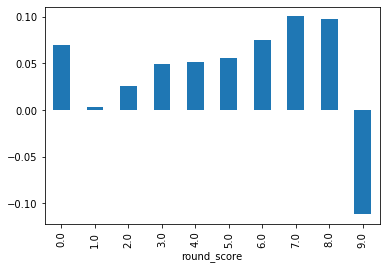

['Application Software']
2007
             Ticker  close_pct
round_score                   
3.0               2   0.011298
4.0               1   0.213667
5.0               2   0.037386


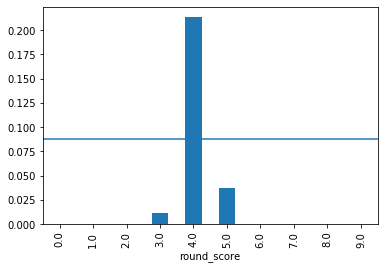

['Application Software']
2008
             Ticker  close_pct
round_score                   
4.0               2  -0.138284
5.0               3  -0.074141


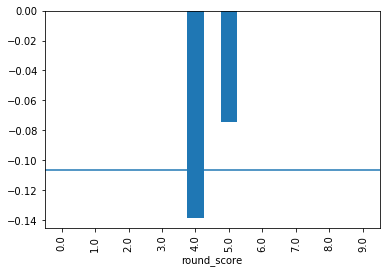

['Application Software']
2009
             Ticker  close_pct
round_score                   
3.0               2  -0.007811
4.0               2  -0.096019
5.0               4   0.120963


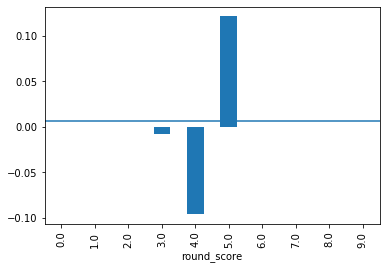

['Application Software']
2010
Empty DataFrame
Columns: [Ticker, close_pct]
Index: []


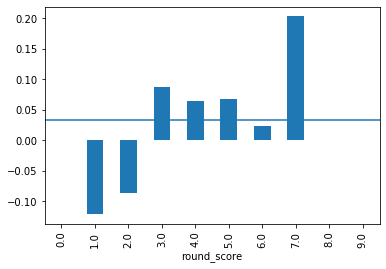

['Application Software']
2011
             Ticker  close_pct
round_score                   
1.0               3  -0.121371
2.0               5  -0.087032
3.0              30   0.087911
4.0              31   0.063755
5.0              20   0.067264
6.0              27   0.022528
7.0               4   0.202969


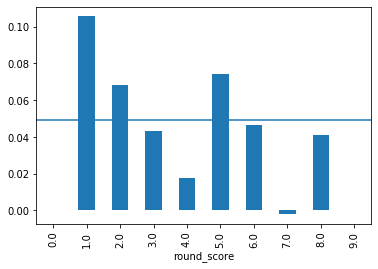

['Application Software']
2012
             Ticker  close_pct
round_score                   
1.0              10   0.105607
2.0              22   0.068338
3.0              46   0.043146
4.0              79   0.017473
5.0              52   0.074413
6.0              29   0.046219
7.0               8  -0.002061
8.0               1   0.041283


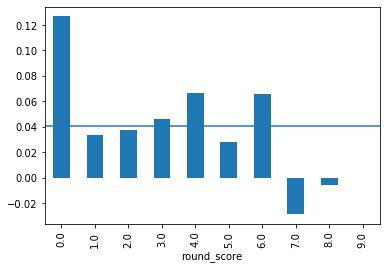

['Application Software']
2013
             Ticker  close_pct
round_score                   
0.0               2   0.126637
1.0               4   0.033185
2.0              48   0.037139
3.0              94   0.046131
4.0              74   0.066750
5.0              63   0.027993
6.0              25   0.065666
7.0              12  -0.028555
8.0               2  -0.005843


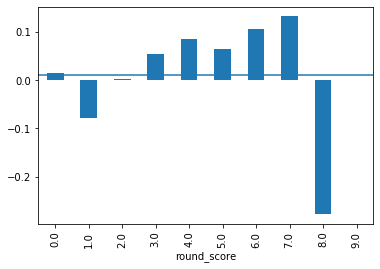

['Application Software']
2014
             Ticker  close_pct
round_score                   
0.0               2   0.015446
1.0              13  -0.078980
2.0              58   0.001725
3.0              95   0.054162
4.0              83   0.084830
5.0              69   0.064980
6.0              39   0.106150
7.0              13   0.131784
8.0               3  -0.277686


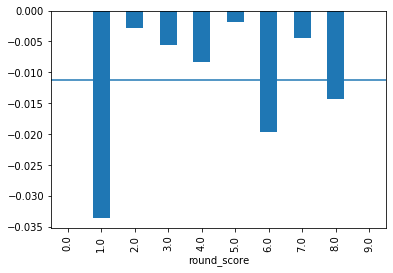

['Application Software']
2015
             Ticker  close_pct
round_score                   
1.0              20  -0.033530
2.0              61  -0.002750
3.0             105  -0.005494
4.0             108  -0.008379
5.0              80  -0.001904
6.0              32  -0.019739
7.0              23  -0.004379
8.0               9  -0.014383


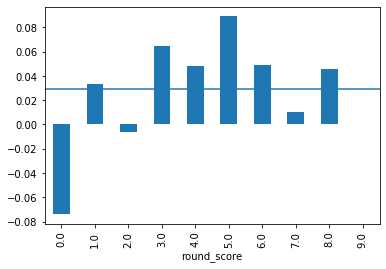

['Application Software']
2016
             Ticker  close_pct
round_score                   
0.0               1  -0.073913
1.0              28   0.033048
2.0              58  -0.005911
3.0             126   0.064945
4.0             115   0.048342
5.0              92   0.089031
6.0              31   0.049102
7.0              20   0.010344
8.0               9   0.046055


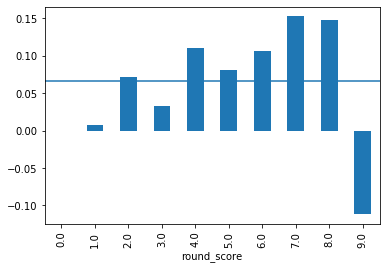

['Application Software']
2017
             Ticker  close_pct
round_score                   
1.0              31   0.007828
2.0              71   0.071238
3.0             115   0.033328
4.0             114   0.110143
5.0              84   0.080443
6.0              47   0.106563
7.0              24   0.152537
8.0              11   0.148241
9.0               1  -0.111628


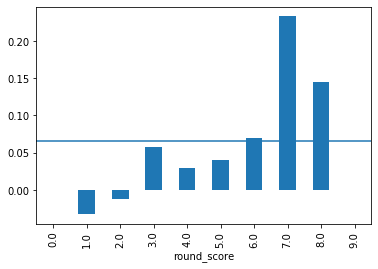

['Application Software']
2018
             Ticker  close_pct
round_score                   
1.0              21  -0.032501
2.0              63  -0.011724
3.0             102   0.057348
4.0             120   0.029185
5.0             108   0.039649
6.0              50   0.070177
7.0              24   0.232785
8.0              21   0.145017


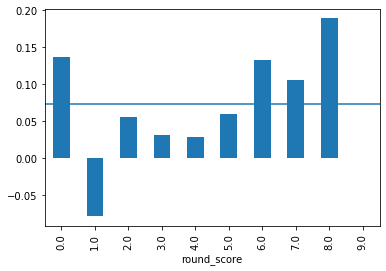

['Application Software']
2019
             Ticker  close_pct
round_score                   
0.0               2   0.136925
1.0              12  -0.078156
2.0              63   0.056339
3.0             157   0.031617
4.0             116   0.028707
5.0              67   0.060070
6.0              55   0.132418
7.0              38   0.105756
8.0               8   0.188993


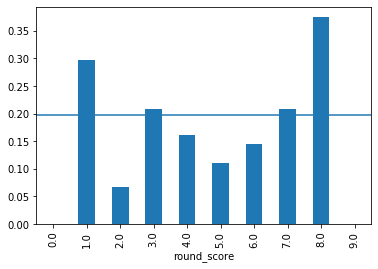

TEST DATASET RESULTS
['Application Software']


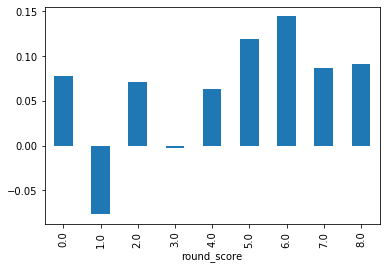

In [16]:
analyze('Application Software')

In [17]:
check_score('AAPL')

AAPL
APPLE INC
Computer Hardware
Price:  114.97
0    cfo_margrow_1_score
1     cfo_growth_1_score
2        cfo_yield_score
3    fcf_margrow_1_score
4     fcf_growth_1_score
5         ev_sales_score
6          cash_mc_score
dtype: object
Value Features: ['cfo_yield_score', 'ev_sales_score']
Quality Features: []
Growth Features: ['cfo_growth_1_score', 'fcf_growth_1_score']
Margin Growth Features: ['cfo_margrow_1_score', 'fcf_margrow_1_score']
Balance Sheet Features: ['cash_mc_score']


Value Weight:  0.28602791374493614
Growth Weight:  0.210282856800197
Quality Weight:  nan
Margin Growth Weight:  0.1907257158650145
Balance Sheet Weight:  0.3129635135898524


Value Score: 2.0
Quality Score: nan
Growth Score: 5.0
Margin Growth Score: 5.5
Balance Sheet Score: 1.0
Total Score: 2.9854250623382894


,AAPL,AAPL,mean,std,min,25%,50%,75%
cfo_margrow_1,0.088182,5.0,0.535109,60.771395,-397.727495,-0.470046,0.010386,0.313995
cfo_growth_1,0.137536,5.0,0.084999,37.688102,-351.320856,-0.412109,0.062866,0.391080
cfo_yield,0.039240,3.0,0.052203,0.171919,-4.314383,0.029401,0.060930,0.099411
fcf_margrow_1,0.141243,6.0,0.304619,35.577079,-861.224915,-0.638925,-0.006528,0.443902
fcf_growth_1,0.187725,5.0,0.335178,33.376067,-806.154472,-0.600278,0.053276,0.486615
ev_sales,7.517166,1.0,3.411451,22.069156,-0.554132,0.571138,1.317153,2.522301
cash_mc,0.045624,1.0,0.177406,0.166580,0.000000,0.073063,0.135382,0.232893


# Set DF

Assigning testdf and traindf as a full dataframe of companies with their scores. Testdf is latest data. Traindf is everything prior.

In [18]:
testdf = fulltest(train.Industry.unique().tolist())
traindf = fulltrain(train.Industry.unique().tolist())

# Long/Short

# Long

Companies with scores greater than 8.

In [19]:
long = testdf[(testdf.round_score >=8)&(testdf.mc>1e+08)&(~testdf.ebitda_margrow_1.isnull())].\
sort_values(['score'], ascending = False )\
[['Ticker','Company Name','Industry','publish_date','score']] 

Check the distribution of industries in the with scores > 8.

In [20]:
long.Industry.value_counts()

Transportation & Logistics       4
Online Media                     3
Retail - Defensive               3
Computer Hardware                3
Industrial Distribution          2
Autos                            2
Entertainment                    2
Semiconductors                   2
Beverages - Alcoholic            1
Application Software             1
REITs                            1
Real Estate Services             1
Farm & Construction Machinery    1
Consumer Packaged Goods          1
Steel                            1
Oil & Gas - Integrated           1
Drug Manufacturers               1
Utilities - Regulated            1
Diversified Holdings             1
Packaging & Containers           1
Name: Industry, dtype: int64

Combine dataframe with score change

In [21]:
empty = []
for x in long.Ticker:
    try:
        empty.append(score_change(x))
    except:
        pass
    
scorechangelong = pd.DataFrame([long.Ticker.tolist(),empty]).transpose().sort_values(by = 1).\
rename(columns = {0:'Ticker', 1: 'scorechange'})

longwchange = pd.merge(long, scorechangelong, how = 'left',on = 'Ticker').sort_values(['scorechange'], ascending = False)

In [41]:
longwchange.sort_values(['publish_date'],ascending = False).head(10)

,Ticker,Company Name,Industry,publish_date,score,scorechange
9,MEIP,"MEI Pharma, Inc.",Drug Manufacturers,2020-09-09,8.331487,1.77867
3,BIG,BIG LOTS INC,Retail - Defensive,2020-09-09,8.821001,0.502442
15,ZM,"Zoom Video Communications, Inc.",Application Software,2020-09-03,7.988076,-0.170761
23,AOSL,ALPHA & OMEGA SEMICONDUCTOR Ltd,Semiconductors,2020-09-02,7.722259,0.401572
10,KE,"Kimball Electronics, Inc.",Computer Hardware,2020-08-27,8.204123,0
30,AIT,APPLIED INDUSTRIAL TECHNOLOGIES INC,Industrial Distribution,2020-08-14,7.572632,0.126925
18,DXPE,DXP ENTERPRISES INC,Industrial Distribution,2020-08-10,7.929474,1.63091
20,BRKA,BERKSHIRE HATHAWAY INC,Diversified Holdings,2020-08-10,7.858916,0.417796
22,RUSHA,RUSH ENTERPRISES INC \TX\,Autos,2020-08-07,7.817985,0
13,YELP,YELP,Online Media,2020-08-07,8.000000,0.584838


In [23]:
check_score('BIG')

BIG
BIG LOTS INC
Retail - Defensive
Price:  50.79
0           cash_mc_score
1      rev_growth_1_score
2       ni_growth_1_score
3       gp_growth_1_score
4         gp_margin_score
5         ev_ebitda_score
6     fcf_margrow_1_score
7      fcf_growth_1_score
8      np_margrow_1_score
9         np_margin_score
10       fcf_margin_score
11    cfo_margrow_1_score
12        cfo_yield_score
13    lt_invest_apr_score
14       cfo_margin_score
15    ebitda_margin_score
16     cfo_growth_1_score
17        fcf_yield_score
dtype: object
Value Features: ['ev_ebitda_score', 'cfo_yield_score', 'fcf_yield_score']
Quality Features: ['gp_margin_score', 'np_margin_score', 'fcf_margin_score', 'cfo_margin_score', 'ebitda_margin_score']
Growth Features: ['rev_growth_1_score', 'ni_growth_1_score', 'gp_growth_1_score', 'fcf_growth_1_score', 'cfo_growth_1_score']
Margin Growth Features: ['fcf_margrow_1_score', 'np_margrow_1_score', 'cfo_margrow_1_score']
Balance Sheet Features: ['cash_mc_score', 'lt_invest_ap

,BIG,BIG,mean,std,min,25%,50%,75%
cash_mc,0.449013,9.0,0.059708,0.068950,0.000182,0.013572,0.032901,0.083921
rev_growth_1,0.095958,7.0,0.055753,0.117550,-0.901325,0.011803,0.044338,0.096342
ni_growth_1,0.829360,9.0,-0.322977,3.347753,-40.842784,-0.181659,0.057925,0.277604
gp_growth_1,0.091818,7.0,0.051733,0.119651,-1.106938,0.011730,0.049108,0.099368
gp_margin,0.401434,9.0,0.261431,0.087832,0.058579,0.211456,0.271122,0.313905
ev_ebitda,1.020978,10.0,10.780318,17.626514,-217.612349,7.743063,10.163565,12.918526
fcf_margrow_1,1.021116,8.0,7.804196,208.614795,-103.289246,-0.862209,-0.021477,0.382596
fcf_growth_1,1.019090,8.0,7.764910,206.971279,-98.000000,-0.778300,0.028395,0.418578
np_margrow_1,0.811248,9.0,-0.444856,3.632600,-44.986144,-0.262010,-0.001889,0.221571
np_margin,0.123251,9.0,0.027074,0.032101,-0.083186,0.012899,0.022693,0.038117


# High Middle

Companies with scores 6 or 7.

In [24]:
highmiddle = testdf[(testdf.round_score >=6)&(testdf.round_score <=7)&(testdf.mc>1e+08)&(~testdf.ebitda_margrow_1.isnull())].\
sort_values(['score'], ascending = False )\
[['Ticker','Company Name','Industry','publish_date','score','mc']] 

In [25]:
empty = []
for x in highmiddle.Ticker:
    try:
        empty.append(score_change(x))
    except:
        pass
    
scorechangehighmiddle = pd.DataFrame([highmiddle.Ticker.tolist(),empty]).transpose().sort_values(by = 1).\
rename(columns = {0:'Ticker', 1: 'scorechange'})

highmiddlewchange = pd.merge(highmiddle, scorechangehighmiddle, how = 'left',on = 'Ticker').\
sort_values(['mc','publish_date'], ascending = False)

In [42]:
highmiddlewchange.sort_values('publish_date').head(10)

,Ticker,Company Name,Industry,publish_date,score,mc,scorechange
236,ESL,ESTERLINE TECHNOLOGIES CORP,Aerospace & Defense,2019-02-05,5.615531,3.641628e+09,-0.297996
198,QTNA,QUANTENNA COMMUNICATIONS INC,Semiconductors,2019-04-30,5.808543,9.858167e+08,-0.370929
40,VRA,"Vera Bradley, Inc.",Manufacturing - Apparel & Furniture,2019-06-12,6.862274,2.466898e+08,0.0969027
225,TOWR,"Tower International, Inc.",Autos,2019-07-25,5.686648,6.518394e+08,1.21659
73,DATA,Tableau Software Inc,Application Software,2019-07-31,6.599355,1.438407e+10,-0.15792
139,PCMI,"PCM, INC.",Computer Hardware,2019-08-08,6.125838,4.529856e+08,-0.184014
178,SYRG,SRC Energy Inc.,Oil & Gas - E&P,2019-11-06,5.920358,9.736617e+08,-0.816056
57,WAIR,"Wesco Aircraft Holdings, Inc",Industrial Distribution,2019-11-26,6.713684,1.106640e+09,-0.356842
89,COUP,Coupa Software Inc,Application Software,2019-12-03,6.479141,1.789751e+10,0.40527
149,ZAYO,"Zayo Group Holdings, Inc.",Communication Equipment,2020-02-04,6.061525,8.330244e+09,0.210283


In [27]:
highmiddle.Industry.value_counts()

Application Software                   25
Industrial Products                    17
Computer Hardware                      15
Retail - Apparel & Specialty           12
Semiconductors                         11
Autos                                  10
Business Services                       8
Communication Services                  8
Retail - Defensive                      7
Building Materials                      7
REITs                                   7
Manufacturing - Apparel & Furniture     6
Oil & Gas - E&P                         6
Medical Diagnostics & Research          6
Restaurants                             5
Steel                                   5
Chemicals                               5
Medical Devices                         5
Oil & Gas - Midstream                   5
Utilities - Regulated                   4
Industrial Distribution                 4
Asset Management                        4
Communication Equipment                 4
Farm & Construction Machinery     

# Short

Companies with scores less than or equal to 2.

In [28]:
short = testdf[(testdf.round_score <=2)&(testdf.mc>1e+08)&(~testdf.ebitda_margrow_1.isnull())].\
sort_values(['publish_date','score'], ascending = False )\
[['Ticker','Company Name','Industry','publish_date','score']] 

In [29]:
empty = []
for x in short.Ticker:
    try:
        empty.append(score_change(x))
    except:
        pass
    
scorechangeshort = pd.DataFrame([short.Ticker.tolist(),empty]).transpose().sort_values(by = 1).\
rename(columns = {0:'Ticker', 1: 'scorechange'})

shortwchange = pd.merge(short, scorechangeshort, how = 'left',on = 'Ticker').\
sort_values(['scorechange'], ascending = False)

In [46]:
shortwchange.sort_values('publish_date').head(10)

,Ticker,Company Name,Industry,publish_date,score,scorechange
178,CHSP,Chesapeake Lodging Trust,REITs,2019-08-01,1.588309,None
177,VSM,"Versum Materials, Inc.",Chemicals,2019-08-06,1.819977,None
176,HRS,HARRIS CORP /DE/,Communication Equipment,2019-10-31,1.632691,None
175,GCI,"Gannett Co., Inc.",Publishing,2019-11-05,1.731780,None
174,VFC,V F CORP,Manufacturing - Apparel & Furniture,2020-02-04,1.175214,None
173,HCHC,"HC2 HOLDINGS, INC.",Communication Services,2020-03-16,2.455344,-0.20103
172,CDE,"Coeur Mining, Inc.",Metals & Mining,2020-04-22,1.807678,-3.0858
171,WTR,Aqua America Inc,Utilities - Regulated,2020-05-08,0.307592,-0.449036
170,MVIS,"MICROVISION, INC.",Computer Hardware,2020-05-08,1.365597,0.0251894
169,NUAN,Nuance Communications Inc,Application Software,2020-05-08,2.450117,-0.446326


In [31]:
check_score('BRKS')

BRKS
BROOKS AUTOMATION INC
Semiconductors
Price:  51.3
0     fcf_margrow_1_score
1    acq_divest_apr_score
2          ev_sales_score
3           cash_mc_score
4               fat_score
5      fcf_growth_1_score
dtype: object
Value Features: ['ev_sales_score']
Quality Features: ['fat_score']
Growth Features: ['fcf_growth_1_score']
Margin Growth Features: ['fcf_margrow_1_score']
Balance Sheet Features: ['acq_divest_apr_score', 'cash_mc_score']


Value Weight:  0.19840188072130152
Growth Weight:  0.21740815160419036
Quality Weight:  0.21498624156078147
Margin Growth Weight:  0.1663943431144405
Balance Sheet Weight:  0.20280938299928616


Value Score: 3.0
Quality Score: 3.0
Growth Score: 0.0
Margin Growth Score: 0.0
Balance Sheet Score: 1.0
Total Score: 1.442973749845535


,BRKS,BRKS,mean,std,min,25%,50%,75%
fcf_margrow_1,-5.597893,0.0,0.051646,9.785829,-124.690246,-0.432065,0.030217,0.424259
acq_divest_apr,NaN,NaN,0.145164,0.380487,-2.253693,0.000758,0.015990,0.164749
ev_sales,4.190386,3.0,3.239013,2.759099,-0.940300,1.246726,2.490547,4.421049
cash_mc,0.068119,1.0,0.225163,0.188055,0.014387,0.100039,0.176156,0.305249
fat,0.569569,3.0,0.751362,0.387741,0.060303,0.499894,0.689195,0.914740
fcf_growth_1,-4.460012,0.0,0.031770,9.961589,-122.107143,-0.376806,0.064041,0.458628


# Low Middle

Companies with scores 3,4,5.

In [32]:
lowmiddle = testdf[(testdf.round_score >=3)&(testdf.round_score <=5)&(testdf.mc>1e+08)&(~testdf.ebitda_margrow_1.isnull())].\
sort_values(['score'], ascending = False )\
[['Ticker','Company Name','Industry','publish_date','score']] 

In [33]:
empty = []
for x in lowmiddle.Ticker:
    try:
        empty.append(score_change(x))
    except:
        pass
    
scorechangelowmiddle = pd.DataFrame([lowmiddle.Ticker.tolist(),empty]).transpose().sort_values(by = 1).\
rename(columns = {0:'Ticker', 1: 'scorechange'})

lowmiddlewchange = pd.merge(lowmiddle, scorechangelowmiddle, how = 'left',on = 'Ticker').\
sort_values(['scorechange'], ascending = False)

In [49]:
lowmiddlewchange.sort_values('publish_date').head(10)

,Ticker,Company Name,Industry,publish_date,score,scorechange
573,SXC,"SunCoke Energy Partners, L.P.",Coal,2019-04-24,3.471903,-0.981238
217,BMS,BEMIS CO INC,Packaging & Containers,2019-04-26,4.670471,0.02265
606,MXWL,MAXWELL TECHNOLOGIES INC,Computer Hardware,2019-05-01,3.326441,-0.428464
765,AYR,Aircastle LTD,Consulting & Outsourcing,2019-05-02,2.695445,-1.61796
134,BRSS,"GLOBAL BRASS & COPPER HOLDINGS, INC.",Industrial Products,2019-05-02,4.921064,-0.325812
197,SFS,"Smart & Final Stores, Inc.",Retail - Defensive,2019-05-03,4.742199,2.11564
155,TVPT,Travelport Worldwide LTD,Travel & Leisure,2019-05-10,4.866940,-0.424238
580,BKS,BARNES & NOBLE INC,Retail - Apparel & Specialty,2019-06-19,3.436935,-0.0121769
562,TYPE,Monotype Imaging Holdings Inc.,Application Software,2019-07-26,3.504734,0.0329199
432,TSS,Total System Services,Credit Services,2019-07-31,3.958467,0.145923


In [35]:
lowmiddle.Industry.value_counts()

Application Software                       82
Computer Hardware                          39
Industrial Products                        37
Retail - Apparel & Specialty               37
Consumer Packaged Goods                    37
Business Services                          28
Semiconductors                             27
Chemicals                                  26
Travel & Leisure                           23
Medical Diagnostics & Research             22
Medical Devices                            22
Utilities - Regulated                      21
Restaurants                                20
REITs                                      20
Online Media                               19
Aerospace & Defense                        19
Manufacturing - Apparel & Furniture        19
Autos                                      18
Communication Equipment                    16
Brokers & Exchanges                        15
Communication Services                     14
Oil & Gas - E&P                   

# End DF

### Companies trading at their 52wk low

In [36]:
daily = sf.asfreq(df = df_prices, freq = 'D', method = 'ffill').reset_index()
start_date = datetime.now() - timedelta(weeks = 104)
end_date = datetime.now()

mask = (daily.Date > start_date) & (daily.Date <= end_date)
maskdf = daily.loc[mask]

high = pd.DataFrame(maskdf.groupby('Ticker').Close.max()).rename(columns = {'Close':'52wkhigh'})
low = pd.DataFrame(maskdf.groupby('Ticker').Close.min()).rename(columns = {'Close':'52wklow'})
highlow = pd.merge(high, low, on = 'Ticker')

prices = pd.merge(maskdf, highlow, on = 'Ticker')
prices['highdiff'] = prices.Close/prices['52wkhigh']
prices['lowdiff'] = prices.Close/prices['52wklow']

In [37]:
latest_date = prices.Date.max()
percentage_change = 0.65
low = prices[(prices.Date == latest_date)&(prices.highdiff < percentage_change)].Ticker.unique()

In [38]:
testdf[testdf.Ticker.isin(low)].sort_values('ev_sales', ascending = 'False')

,Ticker,Company Name,Report Date,publish_date,year,quarter,Sector,Industry,mc,ev,ev_sales,ev_ebitda,ebitda_margin,cf_invest_apr,lt_invest_apr,acq_divest_apr,gp_margin,np_margin,cfo_margin,fcf_margin,fat,cash_mc,fcf_yield,cfo_yield,bs_debt_ebitda,bs_ppe_apev,bs_current_ratio,rev_growth_1,gp_growth_1,oi_growth_1,ni_growth_1,ebitda_growth_1,cfo_growth_1,fcf_growth_1,ebitda_margrow_1,gp_margrow_1,np_margrow_1,cfo_margrow_1,fcf_margrow_1,close_pct,ev_sales_score,ev_ebitda_score,bs_debt_ebitda_score,ebitda_margin_score,gp_margin_score,np_margin_score,cfo_margin_score,fcf_margin_score,fat_score,cash_mc_score,fcf_yield_score,cfo_yield_score,bs_ppe_apev_score,bs_current_ratio_score,cf_invest_apr_score,lt_invest_apr_score,acq_divest_apr_score,rev_growth_1_score,gp_growth_1_score,oi_growth_1_score,ni_growth_1_score,ebitda_growth_1_score,cfo_growth_1_score,fcf_growth_1_score,ebitda_margrow_1_score,gp_margrow_1_score,np_margrow_1_score,cfo_margrow_1_score,fcf_margrow_1_score,value_score,quality_score,growth_score,margrow_score,bs_score,round_value_score,round_quality_score,round_growth_score,round_margrow_score,round_bs_score,score,round_score
1016,AKER,"Akers Biosciences, Inc.",2020-06-30,2020-08-14,2020,Q2,Healthcare,Medical Instruments & Equipment,5.132767e+06,-1.317076e+07,-15.278873,1.442982,-10.588404,3.365788,3.373038,NaN,-0.371801,-10.838523,-6.202881,-6.202881,0.145321,3.566015,-1.041745,-1.041745,0.000000,-1.390073,6.829534,-1.219347,-2.589293,-0.124535,-0.075952,-0.108431,0.180062,0.185769,-0.598274,-1.716109,-0.583640,-0.468284,-0.465712,-0.150735,10.0,8.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,8,9.0,9.0,NaN,0.0,0.0,2.0,3.0,2.0,6.0,6.0,0.0,0.0,1.0,1.0,1.0,2.666667,0.000000,1.666667,1.000000,9.000000,3.0,0.0,2.0,1.0,9.0,3.317118,3.0
1005,AMDA,AMEDICA Corp,2020-06-30,2020-08-12,2020,Q2,Healthcare,Medical Devices,1.223748e+07,-5.466523e+06,-6.538903,0.861073,-7.593900,-1.875598,NaN,NaN,0.200957,-6.336124,-10.040670,-10.290670,0.074133,1.481106,-0.703004,-0.685926,NaN,-3.313990,10.618441,5.750000,20.011905,-0.160446,0.000566,-0.035205,-0.228377,-0.256538,-1.203115,-3.002506,-1.210646,-1.162447,-1.156518,0.200000,10.0,7.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,9,0.0,NaN,NaN,9.0,9.0,2.0,4.0,3.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,2.333333,0.000000,7.000000,NaN,9.000000,2.0,0.0,7.0,NaN,9.0,3.363170,3.0
1506,MARK,"REMARK HOLDINGS, INC.",2020-03-31,2020-07-06,2020,Q1,Technology,Online Media,5.767350e+07,7.098750e+07,-5.066193,-3.917092,1.293356,0.842064,NaN,NaN,0.940480,1.369184,1.607693,1.607693,-0.140818,0.028037,-0.390595,-0.390595,0.000000,0.025314,0.223674,-6.841350,-5.316588,0.520927,-0.147407,0.038129,-0.262840,-0.237138,1.177721,0.261029,1.145958,1.126197,1.130597,-0.148936,10.0,0.0,10.0,9.0,9.0,9.0,9.0,9.0,0.0,0.0,0.0,0.0,1.0,0,9.0,NaN,NaN,0.0,0.0,7.0,3.0,3.0,2.0,2.0,8.0,9.0,8.0,9.0,9.0,0.000000,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,0.0,0.000000,0.0
1281,NSPR,"InspireMD, Inc.",2020-06-30,2020-08-05,2020,Q2,Healthcare,Medical Devices,1.875350e+06,-1.198565e+07,-3.633116,1.353622,-2.683995,0.059715,NaN,NaN,0.170355,-2.753865,-2.202182,-2.238254,0.355343,7.391153,-3.937398,-3.873943,0.000000,-1.194762,4.884888,-0.018490,-0.412811,0.058863,0.060759,0.064035,0.378390,0.383803,0.044718,-0.387162,0.041502,0.353365,0.358680,-0.272727,10.0,7.0,10.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,0.0,0.0,0.0,7,4.0,NaN,NaN,1.0,0.0,4.0,4.0,4.0,7.0,7.0,5.0,0.0,4.0,7.0,7.0,2.333333,0.166667,1.666667,NaN,7.000000,2.0,0.0,2.0,NaN,7.0,2.290367,2.0
1238,HCHC,"HC2 HOLDINGS, INC.",2019-12-31,2020-03-16,2019,Q4,Business Services,Communication Services,1.052800e+08,-3.415820e+09,-1.721597,-32.640420,0.052744,0.132907,0.472053,0.030593,0.281841,-0.015876,0.055693,0.037145,0.305068,41.417173,0.700038,1.049582,8.020067,-1.149621,1.132400,0.003730,0.299893,1.663496,-6.142857,-0.250358,-2.089593,-3.173677,-0.255039,0.297272,-6.162110,-2.101159,-3.189302,0.587838,10.0,0.0,2.0,1.0,0.0,2.0,1.0,3.0,2.0,9.0,9.0,9.0,0.0,5,3.0,9.0,5.0,3.0,9.0,9.0,0.0,1.0,0.0,0.0,1.0,9.0,0.0,0.0,